
Курсовая работа на тему:
«Анализ параметров выходных нейронов глубоких нейронных сетей»
Архитектура № 1

Импортирование библиотек

In [21]:
import numpy as np
import torchvision
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
import seaborn as sns
import pandas as pd

Загрузка датасета MNIST

In [22]:
MNIST_train = torchvision.datasets.MNIST('mnist_data', train=True, download=True)
MNIST_test = torchvision.datasets.MNIST('mnist_data', train=False, download=True)

In [23]:
MNIST_train.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [24]:
print(MNIST_train)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train


In [25]:
print(MNIST_test)

Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test


Преобразовывание данных: X_train и X_test — это изображения цифр в виде двумерных тензоров размера 28x28, приведенных к типу данных float. y_train и y_test — это метки классов, представленные в виде одномерных тензоров.

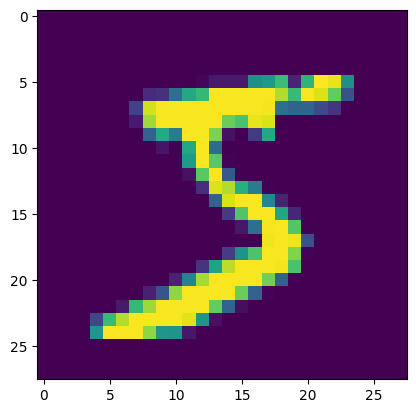

label - 5 - five


In [26]:
X_train = MNIST_train.data.float()
y_train = MNIST_train.targets
X_test = MNIST_test.data.float()
y_test = MNIST_test.targets
plt.imshow(X_train[0, :, :])
plt.show()
print('label -', MNIST_train.classes[y_train[0]])

In [27]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

Создание класса MNIST_ConV для сверточной нейронной сети, унаследованной от класса torch.nn.Module: два сверточных слоя conv1 и conv2, два слоя активации act1 и act2 с функцией активации torch.nn.Tanh(), два слоя пулинга pool1 и pool2, три полносвязных слоя fc1, fc2, fc3

In [28]:
class MNIST_ConV(torch.nn.Module):
    def __init__(self):
        super(MNIST_ConV, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 80)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(80, 40)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(40, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
mnist_conv = MNIST_ConV().cuda()

Обучение модели и вывод метрик

In [29]:
from sklearn.metrics import f1_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_tensor = X_train.cuda()
y_train_tensor = y_train.cuda()
X_test_tensor = X_test.cuda()
y_test_tensor = y_test.cuda()

batch_size = 100
num_epochs = 20
learning_rate = 0.001

mnist_conv.cuda()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_conv.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

test_accuracy_history = []
test_loss_history = []
test_f1_score_history = []

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train_tensor[batch_indexes]
        y_batch = y_train_tensor[batch_indexes]
        
        preds = mnist_conv(X_batch) 
        
        loss_value = criterion(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    with torch.no_grad():
        test_preds = mnist_conv(X_test_tensor)
        test_loss = criterion(test_preds, y_test_tensor)
        test_loss_history.append(test_loss.item())

        accuracy = (test_preds.argmax(dim=1) == y_test_tensor).float().mean()
        test_accuracy_history.append(accuracy.item())
        preds_classes = torch.argmax(test_preds, dim=1)
        f1 = f1_score(y_test_tensor.cpu().numpy(), preds_classes.cpu().numpy(), average='weighted')
        test_f1_score_history.append(f1)
        print(f"Epoch {epoch}: Test accuracy: {accuracy.item()}, Test loss: {test_loss.item()}, F1-score: {f1}") 

Using device: cuda
Epoch 0: Test accuracy: 0.976699948310852, Test loss: 0.08132105320692062, F1-score: 0.9766790159894224
Epoch 1: Test accuracy: 0.9850999712944031, Test loss: 0.04965684562921524, F1-score: 0.9850945057872863
Epoch 2: Test accuracy: 0.98499995470047, Test loss: 0.049994755536317825, F1-score: 0.9849958271191963
Epoch 3: Test accuracy: 0.9872999787330627, Test loss: 0.038781702518463135, F1-score: 0.987309407987741
Epoch 4: Test accuracy: 0.9888999462127686, Test loss: 0.0375550203025341, F1-score: 0.9888980490644997
Epoch 5: Test accuracy: 0.9843999743461609, Test loss: 0.04517557844519615, F1-score: 0.984408726400369
Epoch 6: Test accuracy: 0.988099992275238, Test loss: 0.041520752012729645, F1-score: 0.9881058418602426
Epoch 7: Test accuracy: 0.9892999529838562, Test loss: 0.03509477153420448, F1-score: 0.9892959515282262
Epoch 8: Test accuracy: 0.9890999794006348, Test loss: 0.03531475365161896, F1-score: 0.9890960878658603
Epoch 9: Test accuracy: 0.98819994926452

Вывод графического отражения метрики F1-score 

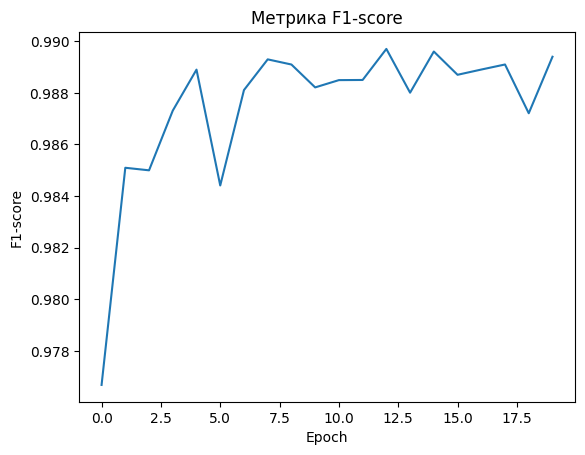

In [30]:
plt.plot(test_f1_score_history)
plt.title("Метрика F1-score")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.show()

Вывод весов последнего слоя нейронной сети

In [31]:
last_layer_weights = mnist_conv.fc3.weight
print(last_layer_weights)

Parameter containing:
tensor([[ 0.0860, -0.6349,  0.4727, -0.6895,  0.1327, -0.3869, -0.2398, -0.5807,
          0.2013,  0.3115, -0.3982,  0.5222,  0.7134,  0.3413, -0.3476, -0.4149,
          0.5991, -0.2467, -0.5571, -0.3617, -0.0657, -0.2854,  0.6220,  0.1731,
          0.5234,  0.7336, -0.3976, -0.0790,  0.6433,  0.5518, -0.6496,  0.3163,
         -0.5240, -0.7071,  0.7924, -0.2247, -0.6785, -0.4411,  0.4575,  0.6373],
        [ 0.5235,  0.5349, -0.4000, -1.0163,  0.5086,  0.4485,  0.5381, -0.0030,
         -0.5619, -0.4754,  0.4533, -0.1979,  0.3283, -0.5965, -0.4362, -0.4204,
         -0.0822,  0.5466,  0.5960,  0.3862,  0.6575,  0.3812, -0.3282, -0.4206,
         -0.6604,  0.1640,  0.3320,  0.4724, -0.3104, -0.2965, -0.0799, -0.3623,
         -0.1372,  0.3565,  0.7177, -0.4972,  0.3064, -0.4779, -0.6084, -0.2598],
        [-0.4415, -0.1829, -0.2752,  0.5197, -0.3601,  0.0650,  0.3981,  0.6358,
          0.7270, -0.4434, -0.7763,  0.4971, -0.3438,  0.6835,  0.5475, -0.3315,
    

Вывод смещений последнего слоя нейронной сети

In [32]:
last_layer_bias = mnist_conv.fc3.bias
print(last_layer_bias)

Parameter containing:
tensor([-0.0741, -0.0639,  0.0502,  0.0195,  0.0852,  0.1444, -0.1300, -0.0055,
        -0.1897,  0.1285], device='cuda:0', requires_grad=True)


Графическое отображение результатов обучения модели нейронной сети

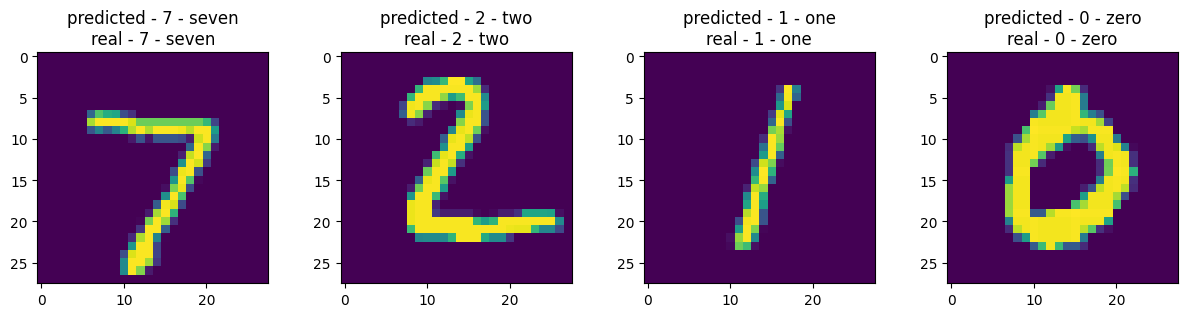

In [33]:
def show_sample(model, X, y, dataset):
    y_pred = model.forward(X)
    X = X.cpu().numpy()
    fig, ax = plt.subplots(1, 4, figsize=(15, 3))
    for i in range(4):
        ax[i].imshow(X[i].reshape(28, 28))
        ax[i].set_title(f'predicted - {dataset.classes[y_pred[i].argmax()]}\nreal - {dataset.classes[y[i]]}')
    
show_sample(mnist_conv, X_test.cuda(), y_test, MNIST_test)

Вывод тепловой карты (heatmap) для матрицы попарных классификационных ошибок модели на тестовом наборе данных. 

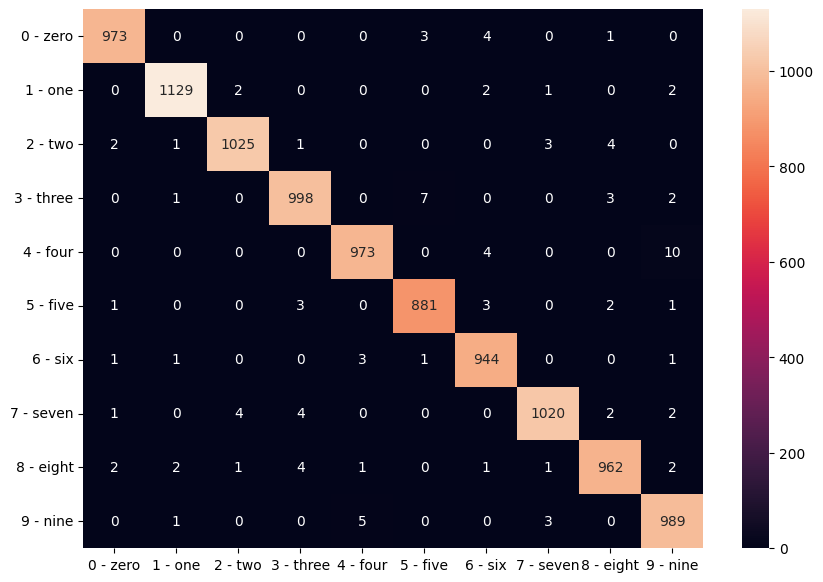

In [34]:
def show_matrix(model, X, y, dataset):
    heat_map_matrix = torch.zeros((len(dataset.classes), len(dataset.classes)))
    y_pred = model.forward(X).argmax(axis=1)
    for i in range(len(y)):
        heat_map_matrix[y_pred[i], y[i]] += 1
    heat_map_matrix = pd.DataFrame(heat_map_matrix, columns=dataset.classes)
    heat_map_matrix.index = dataset.classes
     
    plt.figure(1, (10, 7))
    sns.heatmap(heat_map_matrix, annot=True, fmt='g')
    plt.show()
show_matrix(mnist_conv, X_test.cuda(), y_test, MNIST_test)

Вывод графического отображения первого сверточного слоя

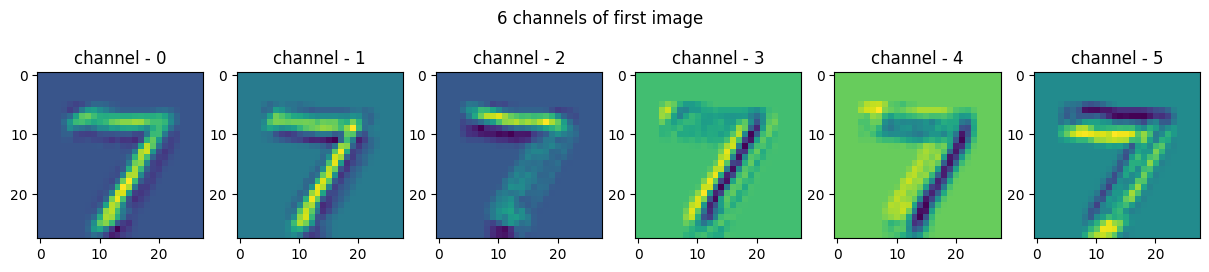

In [36]:
def show_first_conv(model, X, y, dataset):
    count = 1
    with torch.no_grad():
        first_conv = model.conv1(X)
        fig, ax = plt.subplots(1, first_conv[0].size(0), figsize=(15, 3))
        fig.suptitle(f'{first_conv[0].size(0)} channels of first image')
        for i in range(first_conv[0].size(0)):
            if count < 2:
              first_conv = first_conv.cpu().numpy()
            count = 2
            ax[i].imshow(first_conv[0][i])
            ax[i].set_title(f'channel - {i}')

show_first_conv(mnist_conv, X_test.cuda(), y_test, MNIST_test)